# Notebook for Determining Global Variables

__About:__  
The most challenging and most influential step in the data processing is the center finding. Use this notebook to optimize the global variables that are used in both the center finding algorithm including `CENTER_GUESS`, `RADIUS_GUESS`, `DISK_RADIUS`, and `THRESHOLD` and the masking algorithm including `MASK_CENTER`, `MASK_RADIUS`, and `ADDED_MASK`  
  
 __!! Each time you change a global variable, restart your kernel and rerun the following code blocks until you're happy with the result !!__

## Global Variable Usage
The package `gued.py` relies on a few global variables which should be optimized for each experiment. The global variables are stored in `gued_globals.py` and follow standard formatting of all caps (i.e., CENTER_GUESS = (470, 450)). Running the cell below writes any updates to the `gued_globals.py` file. If changes are made, restart notebook to apply. 

In [1]:
%%writefile gued_globals.py 
"""Python file for establishing global variables that change from experiment to experiment. Each global variable should be notated with 
all caps."""
### Global Variables for demo data set
# Variable for reading files
PATH_SEPARATOR = '/' # input how folders are separator in the file path
SEPARATORS = '_' # underscore or dash usually, based on how the files are named

# Variables for Center Finding Algorithm
CENTER_GUESS = (465, 475)
RADIUS_GUESS = 35
DISK_RADIUS = 3 
THRESHOLD = 3000

# Variable for Generating Background
CORNER_RADIUS = 20
CHECK_NUMBER = 50

# Variables for Masking
MASK_CENTER = [525, 515] # x, y position for mask
MASK_RADIUS = 50 # radius for mask
#ADDED_MASK = [[546, 470, 40]]
ADDED_MASK = []

# Used throughout code as the threshold for cutting out date. This is the default value but other values can be set for the functions using this variable
STD_FACTOR = 3

# Specifies the maximum number of workers to be used when running concurrent.futures
MAX_PROCESSORS = 8

# Adjust figure size 
FIGSIZE = (12,4)

# Path for Theory Package
PATH_DCS = '/packages/dcs_repositiory/3.7MeV/'



Overwriting gued_globals.py


## Import Packages

In [2]:
# Standard Packages
import numpy as np
import glob
import matplotlib.pyplot as plt
import random


# new code 
import gued

#interactive plotting 
%matplotlib widget

## Reading in Data and Visualizing

### Defining path -- Uses * to make more accessible for reading in multiple scan files

In [3]:
data_path = "/sdf/data/lcls/ds/ued_testfac/scratch/gued_online_analysis/gued_demo_data/20201027/Run/20201027_1944/"
run_path = "*/*/ANDOR1_*.tif"

full_path = data_path + run_path
print(full_path)

files = glob.glob(full_path) 

print(len(files))


/sdf/data/lcls/ds/ued_testfac/scratch/gued_online_analysis/gued_demo_data/20201027/Run/20201027_1944/*/*/ANDOR1_*.tif
5790


### Reading in All Data and Getting Total Counts

In [4]:
help(gued.get_image_details)

Help on function get_image_details in module gued:

get_image_details(file_names, sort=True, filter_data=False, plot=False)
    Reads all images from input file_names and returns the data as a 3d array along with stage positions, order, and counts per image.
    
    ARGUMENTS:
    
    file_names (list):
        list of file names to be read in
    
    OPTIONAL ARGUMENTS:
    
    sort (boolean): 
        default is set to True. This arguments sorts the data based on when it was saved (i.e. file number)
    plot (boolean): 
        default is set to False. When True, a plot of the data, log(data), and histogram of counts is shown
    filter_data (boolean or list): 
        default is set to False. If you want to select only a fraction of the images, set filter_data = [min_image,]
    
    GLOBAL VARIABLES:
    
    SEPARATORS (list):
        list of strings such as '_' or '-' which are used in the file naming scheme to separate values needed for data analysis (i.e. stage
        posi

Takes ~ 1 min per 1000 images. Can load in fewer images for this notebook. A few hundred is sufficient. 

Loading diffraction signal


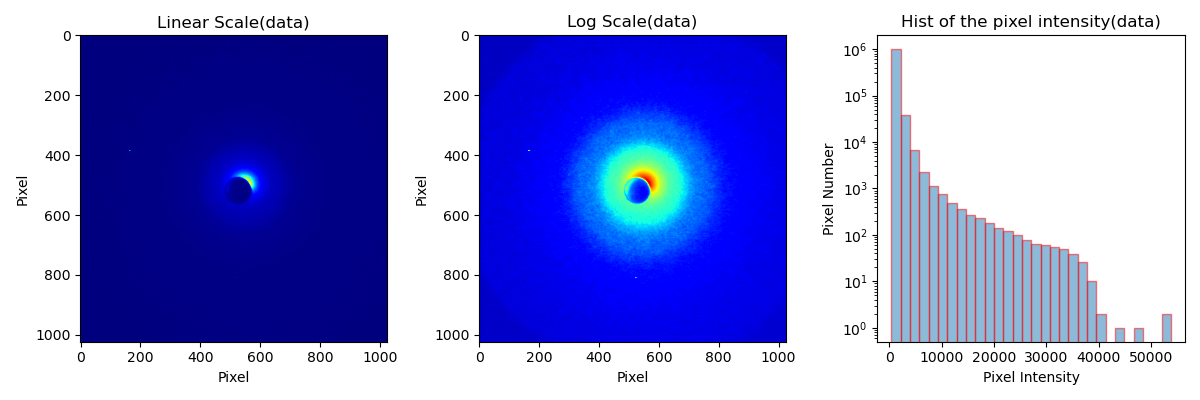

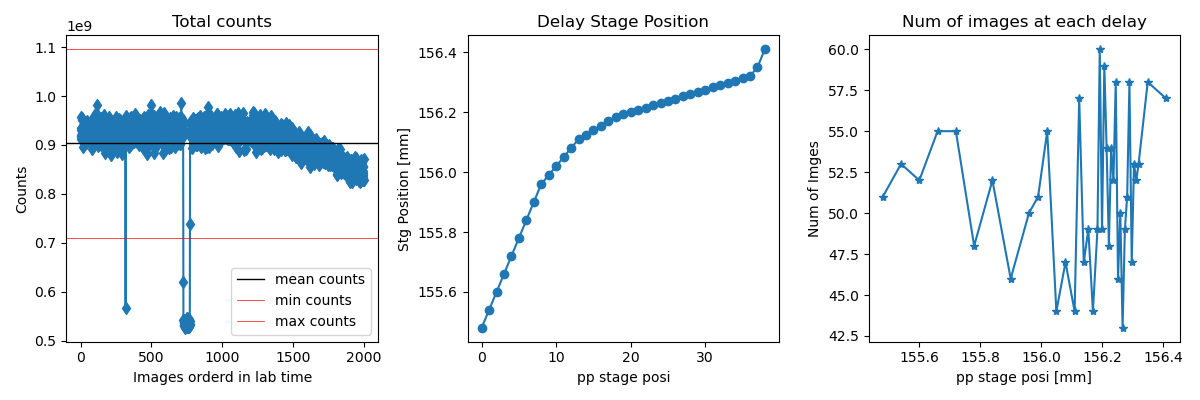

CPU times: user 2.44 s, sys: 2.14 s, total: 4.58 s
Wall time: 5.23 s


In [5]:
%%time
print('Loading diffraction signal')
data_array, stage_positions, file_numbers, counts = gued.get_image_details(files[:2000], sort=True, filter_data=False, plot=True)

## Remove Images with Bad Counts

In [6]:
help(gued.remove_counts)

Help on function remove_counts in module gued:

remove_counts(data_array, stage_positions, file_order, counts, added_range=[], std_factor=3, plot=False)
    Filters input parameters by removing any data where the total counts falls outside of the set filter. Default
    value is set to 3 standard deviations from the mean. Returns the same variables as it inputs but with
    different dimensions.
    
    ARGUMENTS:
    
    data_array (ndarray): 
        Multidimensional array of N x 1024 x 1024 where N is the length of file_names list
    stage_pos (array): 
        One dimensional array of length N containing the stage positions associated with each image.
    file_order (array): 
        One dimensional array of length N that reflects the order with which the images are taken.
    counts(ndarray): 
        One dimensional array of length N containing the total counts after summing over each array
        element.
    
    OPTIONAL ARGUMENTS:
    
    std_factor (int): 
        Defau

48  number of files removed from  2000  initial files


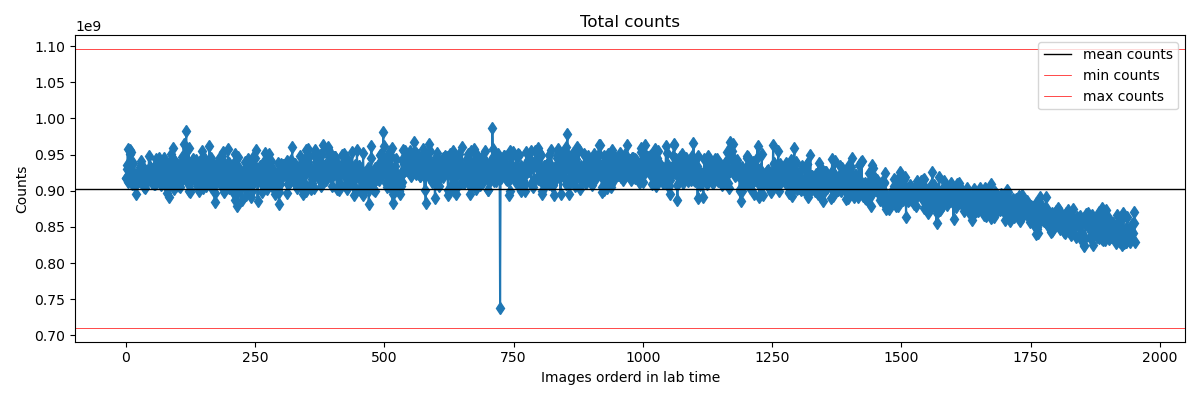

In [7]:
# Remove Outlier Images Based on Total Counts
data_array, stage_positions, file_numbers, counts = gued.remove_counts(data_array, stage_positions, file_numbers, counts, added_range=[], plot=True)


## Create Test Set of Images and process

This code block makes a random selection of 50 files and preprocesses them by removing background based on the corners of the image and removing outlier pixels (x-ray and hot pixels)

In [8]:
file_numbers = list(range(len(data_array)))
rand_idx = random.sample(file_numbers, 50) 
print(np.array(rand_idx))
data_array = data_array[rand_idx]
print("Removing background")
data_array = gued.remove_background_pool(data_array)
print("Removing xrays")
data_array = gued.remove_xrays_pool(data_array, plot=False)

[1129   18  236  314 1103   86 1440 1741 1335 1528 1482  499 1339 1307
  611  339  584 1292  441 1028 1537  916  889 1090 1489  413 1097 1689
 1694  497  431  208 1718  605  860 1814 1619 1378  672 1099  745 1336
 1351 1428  340  136   89  297 1291  192]
Removing background
Removing xrays
Removing hot pixels from all data


## Find Areas to Mask

In [9]:
help(gued.apply_mask)

Help on function apply_mask in module gued:

apply_mask(data_array, fill_value=nan, add_rectangular=False, plot=False, print_vals=False)
    Applies a mask to individual images in the data array.
    
    ARGUMENTS:
    
    data_array (array):
        2D or 3D array of an image or images.
    
    OPTIONAL ARUGMENTS:
    
    fill_value (int, float, or nan):
        Default set to np.nan. Value used to fill the area of the mask.
    add_rectangular (boolean)
        The default is True. Adds an additional mask with rectangular shape. 
    plot (boolean):
        Default set to False. When true, plots a figure with the original data, the masked data, and a contour map of the data
    print_vals (boolean):
        Default set to False. When true, prints the values at each contour line. Useful for setting global variables
    
    GLOBAL VARIABLES:
    
    MASK_CENTER : 1D array, tuple, or list that contains only two values
        Center for generating mask cover unscattered electron b

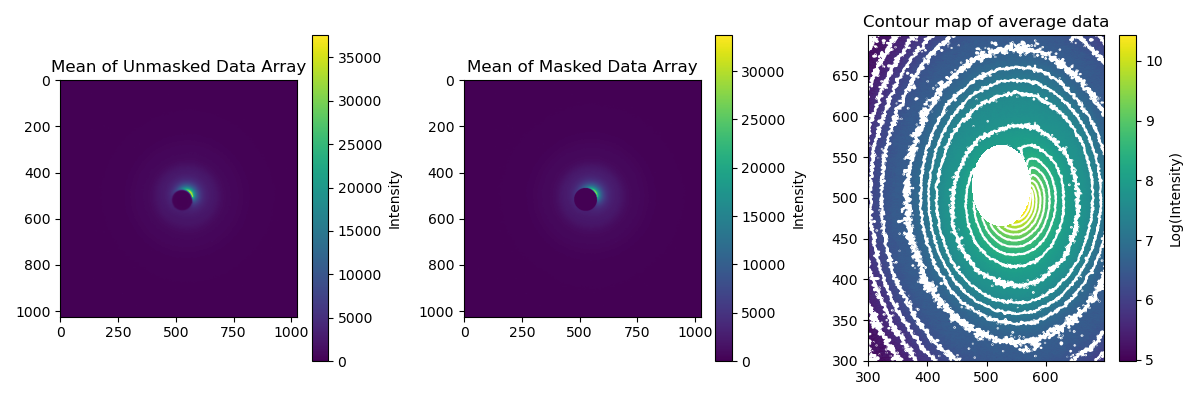

In [10]:
data_array = gued.apply_mask(data_array, fill_value=0.0, plot=True)

## Finding Diffraction Center

In [11]:
help(gued.finding_center_alg) # for one image use this function

Help on function finding_center_alg in module gued:

finding_center_alg(image, plot=False, title='Reference Image')
    Algorithm for finding the center of diffraction pattern
    
    ARGUMENTS:
    
    data_array : 2D array
        Diffraction pattern.
    
    OPTIONAL ARGUMENTS:
    
    thresh_input (float):
        Default set to 0. When zero, the threshold value is calculated using threshold_otsu from scikit-images. Often doesn't work
    plot : boolean, optional
        Show figure of the result of center finding. The default is False.
    title : str, optional
        Title of the figure. The default is 'Reference image'.
    
    
    GLOBAL VARIABLES:
    
    DISK_RADIUS : int, optional
        Generates a flat, disk-shaped footprint. The default is 3.
    CENTER_GUESS : tuple contains 2 values, optional
        Guessing center position to generate temporary mask. The default is (532, 520).
    RADIUS_GUESS : int, optional
        Guessing radius of the temporary mask. The

### Find Average Center

Adjust the `THRESHOLD` value then update the `gued_globals.py` file and restart code

In [12]:
# First, check the threshold value being calculated by the code
from skimage.filters import threshold_otsu
for data in data_array:
    print(threshold_otsu(data))

5570.225270173865
5314.55129743216
5462.363295120778
4996.990938151205
5224.249855807786
4940.40783244334
5100.237561040314
4834.330476667272
5156.440338952232
4784.659421711325
4913.104652040765
5053.912221277969
5059.610354548133
5665.819199742693
5031.579030260118
5136.57478141645
5283.792604857119
5810.630063516581
4677.370230646828
5404.262475935964
5015.557653192251
5472.095298183504
5641.00629016432
5580.582817076569
4700.162983962687
4658.765139762508
5438.569107774479
4665.969256359763
4749.970461972924
5141.65474816883
5392.913094025859
5252.024218913837
5041.187909294878
4961.7937652424625
5435.129625901592
4379.843014869253
5010.9874879904
5079.201454825042
5042.545356201944
5289.047567577577
5177.149451688778
4880.380286358393
5178.490732359978
5229.296686791508
4755.50610456642
5411.317761859873
4940.835488486462
4833.130346969387
5623.895982860132
4888.860795931032


In the left most graph below, you want the yellow to look circular at the smallest radius possible so adjust `THRESHOLD` value to minimize radius values and minimize range of found center values

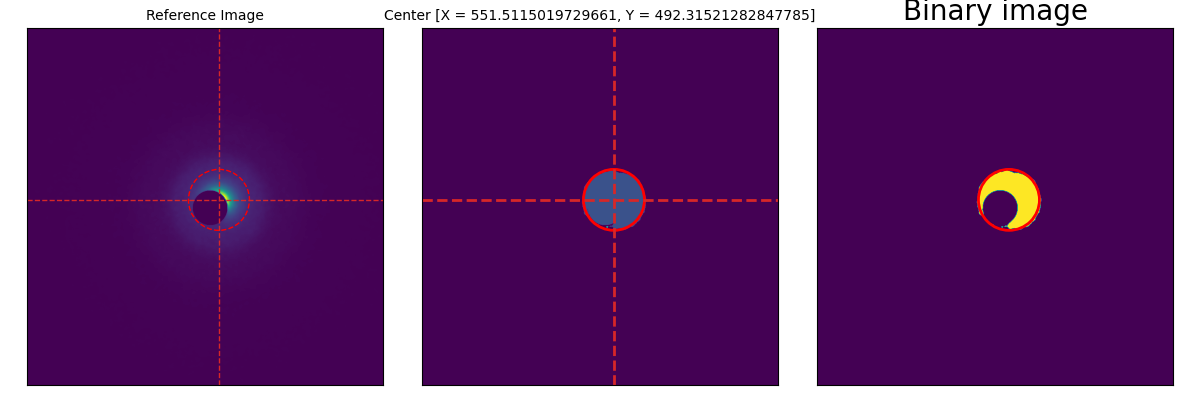

551.5115019729661 492.31521282847785


In [13]:
center_x, center_y, _, _ = gued.finding_center_alg(data_array[0], plot=True)
print(center_x, center_y)

### Find all centers 

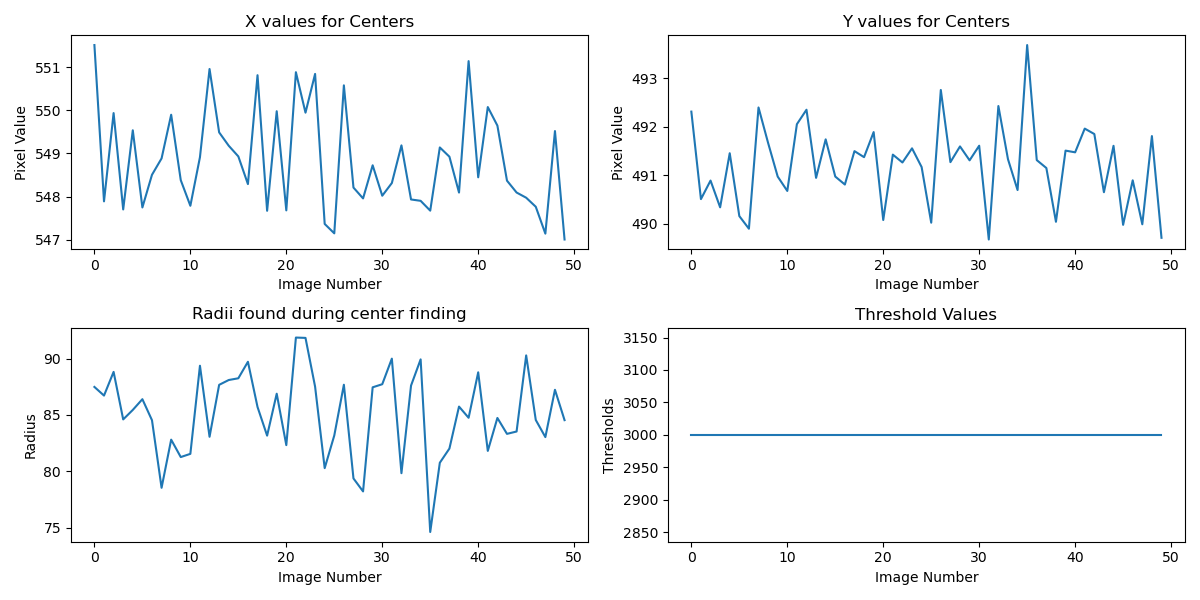

In [14]:
center_x, center_y = gued.find_center_pool(data_array, plot=True)

Now you can run the `Fast_Analysis.ipynb` notebook with the optimized global variables. 